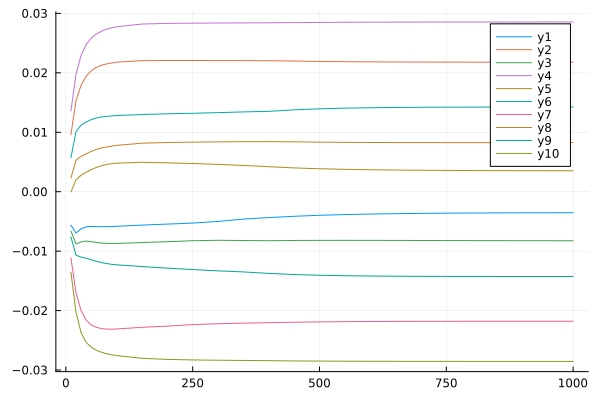

In [5]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots

#Pre-calculate tge probabilities of offspring having a genotype "u"
# given that parents' genotypes are "v" and "w".

#Model parameters: Dempgraphy
nsp=10  #No. of species
a1=0.2
tmean=rand(Uniform(-1,1),nsp)
tvar=rand(Uniform(0.1,0.25),nsp)
r=abs.(rand(Uniform(0,0.1),nsp))

#Quantitative genetic model parameters
n=15    #No. of loci
geno= collect(range(-1,stop=1,length=2*n+1))
nt=length(geno)


Random.seed!(1234)


#Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
# This code follows the diploid version of an exact hypergeometric model
#from Shpak and Kondrashov (1999)
haplR=zeros(Float64,n+1,n+1,n+1)

for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
    haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                          map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
end

for k in 0:n
    haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
    for i1 in 0:n
        haplR[i1+1,i1+1,k+1] /= 2
    end
end

ind_haplR=zeros(Float64,2*n+1, 2*n+1)

for k in 0:n
    for i in 0:n
        ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
        for j in 0:n
            ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
        end
    end
end

R=zeros(Float64,nt,nt,nt)

for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
    R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                        ind_haplR[1+j,1+q .- (0:q)])
end


#Define competition kernels

#The functional forms taken from Taper and Case (1992)
#there are two parameters: sigma (width of a Gaussian shape) and
#theta(asymmetry parameter)

sigma=1.0
theta=0.0
omega=0.2
t=1.0

function alpha_tc(x::Float64, y::Float64, sigma::Float64, theta::Float64)
    
    return exp((sigma^2)*(theta^2))*exp(-((x-y+(2*(sigma^2)*theta))^2)/(4*(sigma^2)))
    
end


function alpha_gt(x::Float64, y::Float64, omega::Float64, t::Float64)

        al=exp(-((x-y)^2)/(omega^2))
        denom=(pi/2)*(erf(t/omega)-erf(-t/omega))
        al/=denom
        
        if(abs(x-y)>t)
            al=0
        end
    
    return al

end


#Pre-calculate coefficients of competition between pairs of genotypes

A1=zeros(Float64,nt,nt)
A0=zeros(Float64,nt,nt)

for i in 1:nt, j in 1:nt
    
    A1[i,j]=a1*alpha_gt(geno[j],geno[i],omega,t)
    
    A0[i,j]=alpha_gt(geno[j],geno[i],omega,t)
    
end


A1= A1 ./ 1000
A0= A0 ./ 1000

#simulate the dynamics

#Initialize phenotypic frequencies

#option 1: All phenotypes are uniformly distributed

N=rand(Uniform(0,1), nsp,nt)

Ng0= N ./ (sum.(eachrow(N)))

Np0= 1000 .* Ng0

Ngen=deepcopy(Ng0)
Np=deepcopy(Np0) 

samples=[collect(0:10:100); collect(100:50:1000)]

result=DataFrame()
#Start the simulation

for m in 1:1000
    
    #Determine the extinct species
    Np[findall(sum(Np,dims=2) .< 10),:] .= 0
    
    if all(sum(Np,dims=2) ==0) 
        break
    else
    
        newgen=zeros(Float64,nsp,nt)

        #Reproduction event
        for i in 1:size(Ngen)[1]

            probs=Ngen[i,:]*Ngen[i,:]'

            for j in 1:size(R)[3]
                newgen[i,j]=sum(probs.*R[:,:,j])
            end
        end

        newp=newgen .* sum(Np,dims=2)

        #Selection event

        for i in 1:size(newp)[1], j in 1:size(newp)[2]

            comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
            Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

        end

        Np[findall(Np .<1)] .= 0
        Ngen= Np ./ sum(Np,dims=2)
    end
    
    if m âˆˆ samples
        
        dat1=DataFrame(time=m,sp=1:nsp,trmean=mean.(eachrow(geno' .*Ngen)))
        
        append!(result,dat1)
    end

end   

result=unstack(result,:sp,:trmean)
result=Matrix(result)
plot(result[:,1],result[:,2:end])



In [4]:
reps=collect(1:50)
a1s=[0.1,0.5,1]
loci=[3,5,10,15,20]
omegas=[0.1,0.5]
t=[0.2,0.5,2]

pars=collect(Iterators.product(reps,a1s,loci,omegas,t))

length(pars)

4500

In [ ]:
plot(result[:,1],result[:,2:end])

In [ ]:
#plots
using Plots

plot(geno, Ngen')

In [ ]:
dat=DataFrame()

dat1=DataFrame(time=0,sp=1:10,trmean=mean.(eachrow(geno' .*Ngen)))

append!(dat,dat1)

In [ ]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions

#Pre-calculate tge probabilities of offspring having a genotype "u"
# given that parents' genotypes are "v" and "w".

#Model parameters: Dempgraphy
nsp=10  #No. of species
a1=1
a0=1
tmean=rand(Uniform(-1,1),nsp)
tvar=rand(Uniform(0.1,0.25),nsp)
r=abs.(rand(Uniform(0,0.1),nsp))

#Quantitative genetic model parameters
n=5    #No. of loci
geno= collect(range(-1,stop=1,length=2*n+1))
nt=length(geno)


Random.seed!(1234)


#Set up a probability matrix of an offspring having a phenotype x when the parents have the phenotypes v and w resp.
# This code follows the diploid version of an exact hypergeometric model
#from Shpak and Kondrashov (1999)
haplR=zeros(Float64,n+1,n+1,n+1)

for i in 0:n, j in 0:i, k in 0:min(n,(i+j))
    haplR[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),max(0, i+j-n):min(i, j)) .*
                          map(x->pdf(Binomial(i+j-2*x),k-x),collect(max(0, i+j-n):min(i,j))))
end

for k in 0:n
    haplR[:,:,1+k]=haplR[:,:,1+k]+transpose(haplR[:,:,1+k])
    for i1 in 0:n
        haplR[i1+1,i1+1,k+1] /= 2
    end
end

ind_haplR=zeros(Float64,2*n+1, 2*n+1)

for k in 0:n
    for i in 0:n
        ind_haplR[1+i,1+k] = haplR[1+i,1,1+k]
        for j in 0:n
            ind_haplR[1+j+n,1+k]=haplR[1+n,1+j,1+k]
        end
    end
end

R=zeros(Float64,nt,nt,nt)

for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
    R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                        ind_haplR[1+j,1+q .- (0:q)])
end

In [ ]:
Ngen

In [ ]:
#Start the simulation


    
    #Determine the extinct species
    Np[findall(sum(Np,dims=2) .< 10),:] .= 0
    
    newgen=zeros(Float64,nsp,nt)
    
    #Reproduction event
    for i in 1:size(Ngen)[1]
        
        probs=Ngen[i,:]*Ngen[i,:]'
        
        for j in 1:size(R)[3]
            newgen[i,j]=sum(probs.*R[:,:,j])
        end
    end
    
    

    newp=newgen .* sum(Np,dims=2)

    #Selection event

    for i in 1:size(newp)[1], j in 1:size(newp)[2]
        
        comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
        Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))
    
    end
    
    Np[findall(Np .<10)] .= 0
    Ngen= Np ./ sum(Np,dims=2)

        
    